✅ GPU Detected: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}
✅ Dataset path dynamically detected: /root/.cache/kagglehub/datasets/atreyamajumdar/mstar-dataset-8-classes/versions/1/Padded_imgs
✅ Found 8 classes: ['2S1', 'BRDM_2', 'BTR_60', 'D7', 'SLICY', 'T62', 'ZIL131', 'ZSU_23_4']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
    474/Unknown 111s 193ms/step - accuracy: 0.7795 - loss: 0.7056

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


474/474 ━━━━━━━━━━━━━━━━━━━━ 129s 229ms/step - accuracy: 0.7797 - loss: 0.7048 - val_accuracy: 0.9546 - val_loss: 0.1333
Epoch 2/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 99s 210ms/step - accuracy: 0.9603 - loss: 0.1253 - val_accuracy: 0.9778 - val_loss: 0.0737
Epoch 3/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 142s 209ms/step - accuracy: 0.9771 - loss: 0.0813 - val_accuracy: 0.9852 - val_loss: 0.0497
Epoch 4/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 99s 209ms/step - accuracy: 0.9801 - loss: 0.0619 - val_accuracy: 0.9768 - val_loss: 0.0688
Epoch 5/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 99s 209ms/step - accuracy: 0.9783 - loss: 0.0604 - val_accuracy: 0.9810 - val_loss: 0.0473
Epoch 6/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 99s 210ms/step - accuracy: 0.9821 - loss: 0.0562 - val_accuracy: 0.9894 - val_loss: 0.0304
Epoch 7/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 99s 209ms/step - accuracy: 0.9849 - loss: 0.0448 - val_accuracy: 0.9905 - val_loss: 0.0326
Epoch 8/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 99s 209ms/step - accuracy: 0.9882 - loss: 0.0368 - v

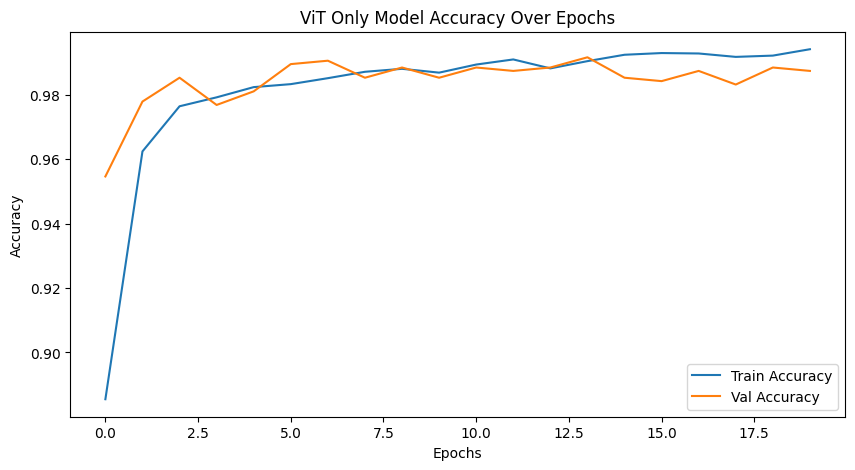

In [2]:

import os
import glob
import cv2
import numpy as np
import tensorflow as tf
import kagglehub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Layer, GlobalAveragePooling1D
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from transformers import TFViTModel
import matplotlib.pyplot as plt
# ✅ Split Dataset
from sklearn.model_selection import train_test_split

# ✅ Enable Mixed Precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# ✅ Enable GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"✅ GPU Detected: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    print("❌ No GPU detected.")

# ✅ Download Dataset
dataset_path = kagglehub.dataset_download("atreyamajumdar/mstar-dataset-8-classes")
if "versions" in dataset_path:
    DATASET_PATH = os.path.join(dataset_path, "Padded_imgs")
else:
    DATASET_PATH = os.path.join(dataset_path, "versions", "1", "Padded_imgs")
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset path does not exist: {DATASET_PATH}")
print(f"✅ Dataset path dynamically detected: {DATASET_PATH}")

# ✅ Load Classes
classes = sorted(os.listdir(DATASET_PATH))
num_classes = len(classes)
print(f"✅ Found {num_classes} classes: {classes}")

# ✅ Load Image Paths & Labels
image_paths, labels = [], []
for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(DATASET_PATH, class_name)
    imgs = glob.glob(class_path + "/*.JPG") + glob.glob(class_path + "/*.jpg")
    image_paths.extend(imgs)
    labels.extend([class_idx] * len(imgs))



# Split the image paths and labels into Train, Validation, and Test sets
img_train, img_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
img_val, img_test, y_val, y_test = train_test_split(img_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Now you can safely use y_val and y_test
train_dataset = vit_image_generator(img_train, y_train, num_classes)
val_dataset = vit_image_generator(img_val, y_val, num_classes)
test_dataset = vit_image_generator(img_test, y_test, num_classes)

# ✅ Image Generator for ViT only
def vit_image_generator(image_paths, labels, num_classes):
    def gen():
        for img_path, label in zip(image_paths, labels):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224)) / 255.0
            yield img, to_categorical(label, num_classes=num_classes)

    output_signature = (
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)
    )
    return tf.data.Dataset.from_generator(gen, output_signature=output_signature).batch(16).prefetch(tf.data.AUTOTUNE)

# ✅ Define ViT Feature Extractor
class ViTFeatureExtractor(Layer):
    def __init__(self, model_name="google/vit-base-patch16-224", **kwargs):
        super(ViTFeatureExtractor, self).__init__(**kwargs)
        self.vit = TFViTModel.from_pretrained(model_name)
        self.vit.trainable = False

    def call(self, inputs, training=False):
        inputs = tf.transpose(inputs, perm=[0, 3, 1, 2])
        vit_outputs = self.vit(pixel_values=inputs, training=training).last_hidden_state
        return GlobalAveragePooling1D()(vit_outputs)

# ✅ Build ViT-only Classifier
vit_input = Input(shape=(224, 224, 3))
vit_features = ViTFeatureExtractor()(vit_input)
x = Dense(256, activation='relu')(vit_features)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
vit_model = Model(inputs=vit_input, outputs=output)

# ✅ Compile
lr_schedule = ExponentialDecay(0.001, decay_steps=10000, decay_rate=0.95, staircase=True)
vit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# ✅ Train
with tf.device('/GPU:0'):
    history = vit_model.fit(train_dataset, validation_data=val_dataset, epochs=20)

# ✅ Evaluate
loss, accuracy = vit_model.evaluate(test_dataset)
print(f"✅ ViT-only Model Accuracy: {accuracy:.4f}")
vit_model.save("/content/mstar_vit_only.keras")
print("🎯 ViT-only model training complete!")

# ✅ Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('ViT Only Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
